In [1]:
import pickle
from Agent_DDH_Class import Agent_DDH
from Agent_Class import Agent_Straddles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import norm
import warnings


with open('DataSet/call_list.pkl', 'rb') as f:
    call_list = pickle.load(f)
with open('DataSet/put_list.pkl', 'rb') as f:
    put_list = pickle.load(f)
with open('DataSet/dates.pkl', 'rb') as f:
    trade_dates = pickle.load(f)
with open('DataSet/date_strs.pkl', 'rb') as f:
    trade_dates_str = pickle.load(f)


In [2]:
underlying_df = pd.read_csv('DataSet/underlying.csv', parse_dates=['Date'])
date_list = underlying_df['Date'].dt.strftime('%Y-%m-%d').tolist()
n_days = len(date_list)

close_prices = underlying_df['Close'].values
underlying_returns = np.diff(close_prices) / close_prices[:-1]
underlying_returns = np.insert(underlying_returns, 0, 0.0)  # align length
cum_underlying = np.cumprod(1 + underlying_returns) - 1

## Initialize Agents

In [ ]:
agent_ddh = Agent_DDH(
    balance=10000.0,
    vega_risk_frac=10,         # e.g., 10% of NAV in vega
    max_vega_per_trade=500,     # cap absolute vega (increased for bravery)
    vrp_threshold=0.001,        # trade only if |VRP_z| > 1.0
    max_leverage=5,           # max notional / NAV
    tx_cost=0,              # 0.5% round-trip (realistic for options)
    rehedge_freq=1000,
    delta_drift_threshold=0.05,  # rehedge if |delta error| > 10% of position
    stop_loss_frac=0.5,        # stop if trade P&L < -15% of premium paid (loosened)
    profit_take_frac=-1.0,      # take profit at +X% of premium (default -1 = disabled)
)

agent_straddle = Agent_Straddles(
    balance=10000.0,
    sizing_method='vega',        # 'vega' or 'premium'
    vega_risk_frac=0.1,          # e.g., 10% NAV in vega
    premium_risk_frac=0.5,      # e.g., 5% NAV per trade
    max_units=100000,                # max contracts per trade
    vrp_threshold=0.05,
    tx_cost=0,               # 0.5% round-trip
    stop_loss_frac=0.5,         # exit if loss > 20% of premium paid
)

c:\Users\Lenovo\Desktop\quant_proj\Volatility-based_Quant_Strategy\Agent_DDH_Class.py:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.underlying_df['RV_30d'].fillna(method='bfill', inplace=True)
c:\Users\Lenovo\Desktop\quant_proj\Volatility-based_Quant_Strategy\Agent_DDH_Class.py:95: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.underlying_df['RV_30d'].fillna(method='bfill', inplace=True)


## Start Back_test

In [10]:


# ==========================
# Initialize result storage
# ==========================
def init_arrays(n):
    return (
        [np.nan] * n,  # nav
        [np.nan] * n,  # gamma
        [np.nan] * n,  # delta
        [np.nan] * n,  # vega
        [np.nan] * n,  # theta
        [np.nan] * n,  # num_options
        [np.nan] * n,  # num_underlying (0 for straddle)
        [''] * n       # trade_events
    )

(nav_ddh, gamma_ddh, delta_ddh, vega_ddh, theta_ddh, 
 opt_ddh, und_ddh, event_ddh) = init_arrays(n_days)

(nav_straddle, gamma_straddle, delta_straddle, vega_straddle, theta_straddle,
 opt_straddle, und_straddle, event_straddle) = init_arrays(n_days)

# ==========================
# Backtest Loop
# ==========================
j_ddh = j_straddle = 0

for i in range(n_days):
    day_str = date_list[i]
    day_dt = pd.to_datetime(day_str)
    
    # ===== Delta-Hedged Agent =====
    agent_ddh.cal_value(day_dt)
    agent_ddh.rehedge(day_dt)
    
    should_exit, reason = agent_ddh.should_exit(day_dt)
    if should_exit:
        agent_ddh.close_position(day_dt, reason=reason)
        event_ddh[i] = f"exit:{reason}"
    
    if day_str in trade_dates_str and j_ddh < len(call_list):
        agent_ddh.build_position(call_list[j_ddh], put_list[j_ddh], day_dt)
        event_ddh[i] = "enter"
        j_ddh += 1
    
    # Record DDH
    nav_ddh[i] = agent_ddh.total_value if not np.isnan(agent_ddh.total_value) else (nav_ddh[i-1] if i > 0 else 10000.0)
    if agent_ddh.trade_open and agent_ddh.greeks:
        gamma_ddh[i] = agent_ddh.greeks['gamma'] * agent_ddh.call_num
        delta_ddh[i] = agent_ddh.greeks['delta'] * agent_ddh.call_num + agent_ddh.underlying_num
        vega_ddh[i] = agent_ddh.greeks['vega'] * agent_ddh.call_num
        theta_ddh[i] = agent_ddh.greeks['theta'] * agent_ddh.call_num / 252
    opt_ddh[i] = agent_ddh.call_num + agent_ddh.put_num
    und_ddh[i] = agent_ddh.underlying_num
    
    # ===== Pure Straddle Agent =====
    agent_straddle.cal_value(day_dt)
    
    should_exit, reason = agent_straddle.should_exit(day_dt)
    if should_exit:
        agent_straddle.close_position(day_dt, reason=reason)
        event_straddle[i] = f"exit:{reason}"
    
    if day_str in trade_dates_str and j_straddle < len(call_list):
        agent_straddle.build_position(call_list[j_straddle], put_list[j_straddle], day_dt)
        event_straddle[i] = "enter"
        j_straddle += 1
    
    # Record Straddle
    nav_straddle[i] = agent_straddle.total_value if not np.isnan(agent_straddle.total_value) else (nav_straddle[i-1] if i > 0 else 10000.0)
    if agent_straddle.trade_open and agent_straddle.greeks:
        gamma_straddle[i] = agent_straddle.greeks['gamma'] * agent_straddle.call_num
        delta_straddle[i] = agent_straddle.greeks['delta'] * agent_straddle.call_num  # no hedge
        vega_straddle[i] = agent_straddle.greeks['vega'] * agent_straddle.call_num
        theta_straddle[i] = agent_straddle.greeks['theta'] * agent_straddle.call_num / 252
    opt_straddle[i] = agent_straddle.call_num + agent_straddle.put_num
    und_straddle[i] = 0.0  # always zero


In [11]:
def compute_metrics(nav_series, name):
    nav = np.array(nav_series)
    nav = np.nan_to_num(nav, nan=10000.0)
    returns = np.diff(nav) / nav[:-1]
    returns = np.insert(returns, 0, 0.0)
    cum_returns = np.cumprod(1 + returns) - 1
    
    sharpe = np.mean(returns) / np.std(returns) * np.sqrt(252) if np.std(returns) > 1e-8 else 0
    annual_vol = np.std(returns) * np.sqrt(252) if np.std(returns) > 1e-8 else 0
    max_dd = (np.maximum.accumulate(nav) - nav).max() / np.maximum.accumulate(nav).max()
    total_ret = cum_returns[-1]
    
    
    return nav, returns, cum_returns, sharpe, annual_vol, max_dd, total_ret

nav_ddh_arr, ret_ddh, cum_ddh, sharpe_ddh, vol_ddh, dd_ddh, tot_ddh = compute_metrics(nav_ddh, "Delta-Hedged")
nav_straddle_arr, ret_straddle, cum_straddle, sharpe_straddle, vol_straddle, dd_straddle, tot_straddle = compute_metrics(nav_straddle, "Pure Straddle")

# ==========================
# Save Results
# ==========================
date_idx = pd.to_datetime(underlying_df['Date'])

result_ddh = pd.DataFrame({
    'Date': date_idx,
    'NAV': nav_ddh_arr,
    'Return': ret_ddh,
    'CumReturn': cum_ddh,
    'Delta': delta_ddh,
    'Gamma': gamma_ddh,
    'Vega': vega_ddh,
    'Theta': theta_ddh,
    'NumOptions': opt_ddh,
    'NumUnderlying': und_ddh,
    'TradeEvent': event_ddh
})

result_straddle = pd.DataFrame({
    'Date': date_idx,
    'NAV': nav_straddle_arr,
    'Return': ret_straddle,
    'CumReturn': cum_straddle,
    'Delta': delta_straddle,
    'Gamma': gamma_straddle,
    'Vega': vega_straddle,
    'Theta': theta_straddle,
    'NumOptions': opt_straddle,
    'NumUnderlying': und_straddle,
    'TradeEvent': event_straddle
})



## Plot result

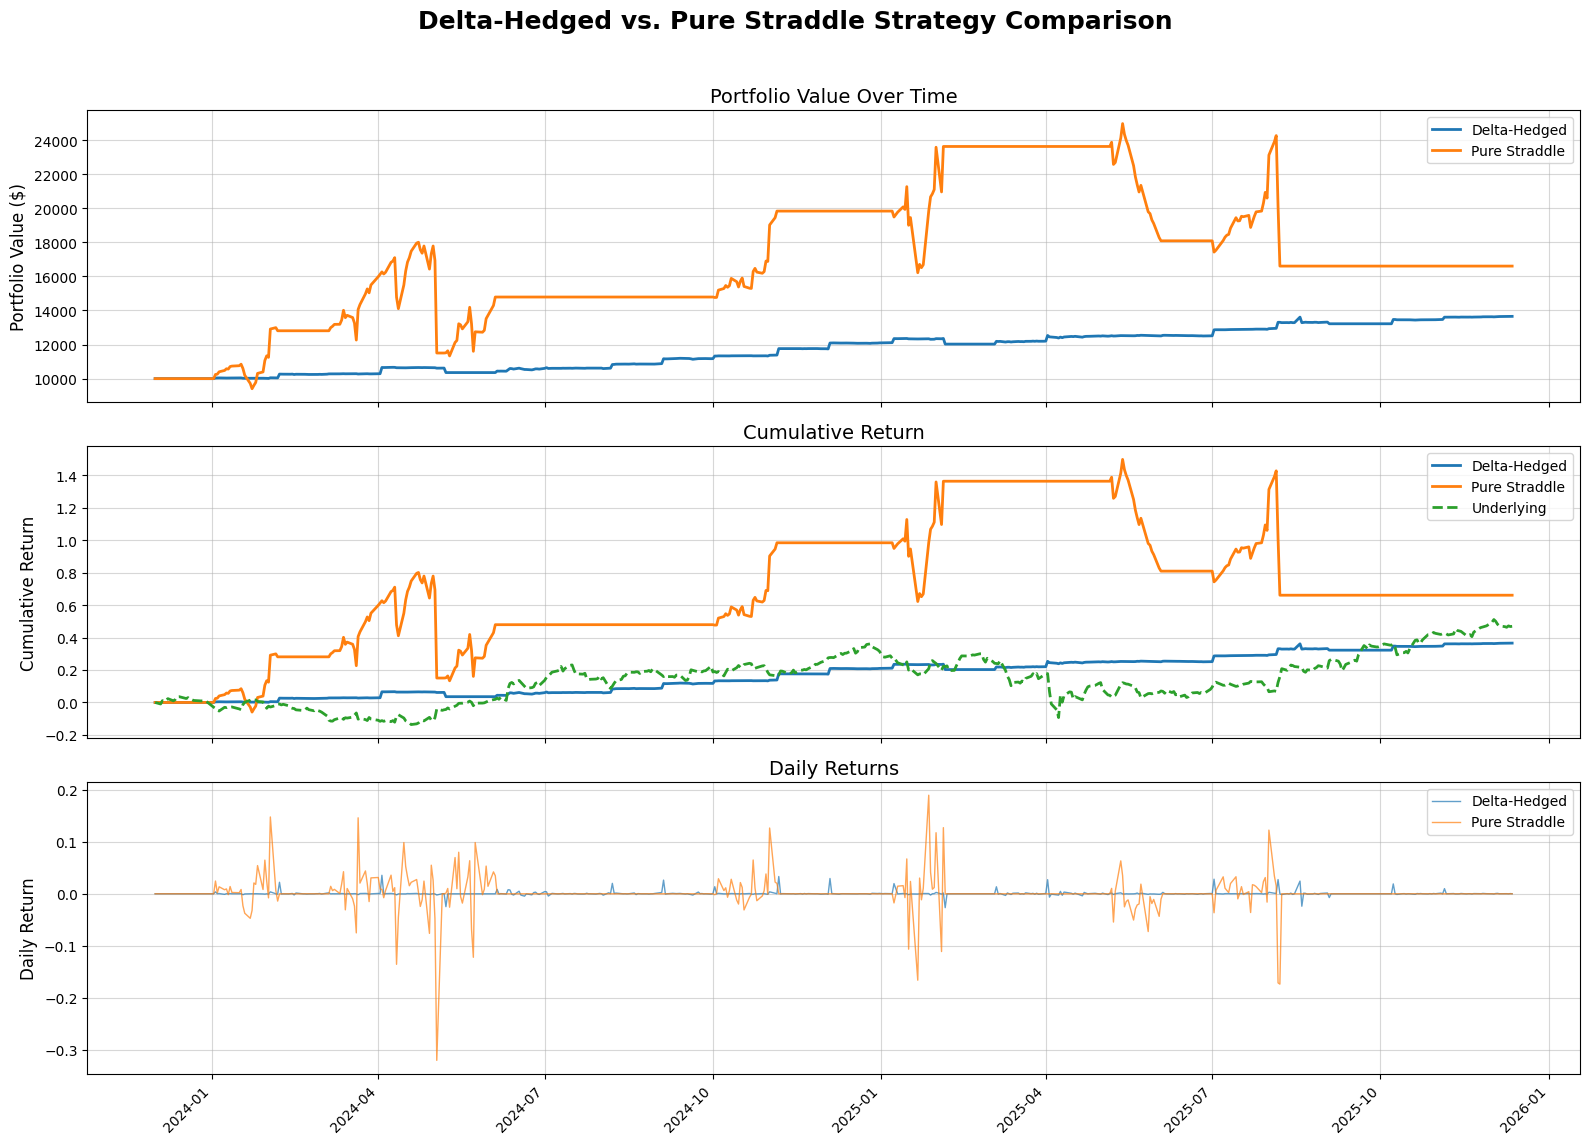

In [12]:
fig, axs = plt.subplots(3, 1, figsize=(16, 12), sharex=True)
fig.suptitle('Delta-Hedged vs. Pure Straddle Strategy Comparison', fontsize=18, fontweight='bold')

# 1. NAV
axs[0].plot(date_idx, nav_ddh_arr, label='Delta-Hedged', color='tab:blue', linewidth=2)
axs[0].plot(date_idx, nav_straddle_arr, label='Pure Straddle', color='tab:orange', linewidth=2)
axs[0].set_ylabel('Portfolio Value ($)', fontsize=12)
axs[0].set_title('Portfolio Value Over Time', fontsize=14)
axs[0].grid(True, alpha=0.5)
axs[0].legend()

# 2. Cumulative Return (with underlying)
axs[1].plot(date_idx, cum_ddh, label='Delta-Hedged', color='tab:blue', linewidth=2)
axs[1].plot(date_idx, cum_straddle, label='Pure Straddle', color='tab:orange', linewidth=2)
axs[1].plot(date_idx, cum_underlying, label='Underlying', color='tab:green', linewidth=2, linestyle='--')
axs[1].set_ylabel('Cumulative Return', fontsize=12)
axs[1].set_title('Cumulative Return', fontsize=14)
axs[1].grid(True, alpha=0.5)
axs[1].legend()

# 3. Daily Returns (histogram inset optional)
axs[2].plot(date_idx, ret_ddh, label='Delta-Hedged', color='tab:blue', alpha=0.7, linewidth=1)
axs[2].plot(date_idx, ret_straddle, label='Pure Straddle', color='tab:orange', alpha=0.7, linewidth=1)
axs[2].set_ylabel('Daily Return', fontsize=12)
axs[2].set_title('Daily Returns', fontsize=14)
axs[2].grid(True, alpha=0.5)
axs[2].legend()

# Format dates
for ax in axs:
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(axs[-1].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

# ==========================
# Summary Table
# ==========================
summary_df = pd.DataFrame({
    'Metric': ['Final NAV', 'Total Return', 'Sharpe Ratio', 'Max Drawdown'],
    'Delta-Hedged': [
        f"${nav_ddh_arr[-1]:,.0f}",
        f"{tot_ddh:.2%}",
        f"{sharpe_ddh:.2f}",
        f"{dd_ddh:.2%}"
    ],
    'Pure Straddle': [
        f"${nav_straddle_arr[-1]:,.0f}",
        f"{tot_straddle:.2%}",
        f"{sharpe_straddle:.2f}",
        f"{dd_straddle:.2%}"
    ]
})

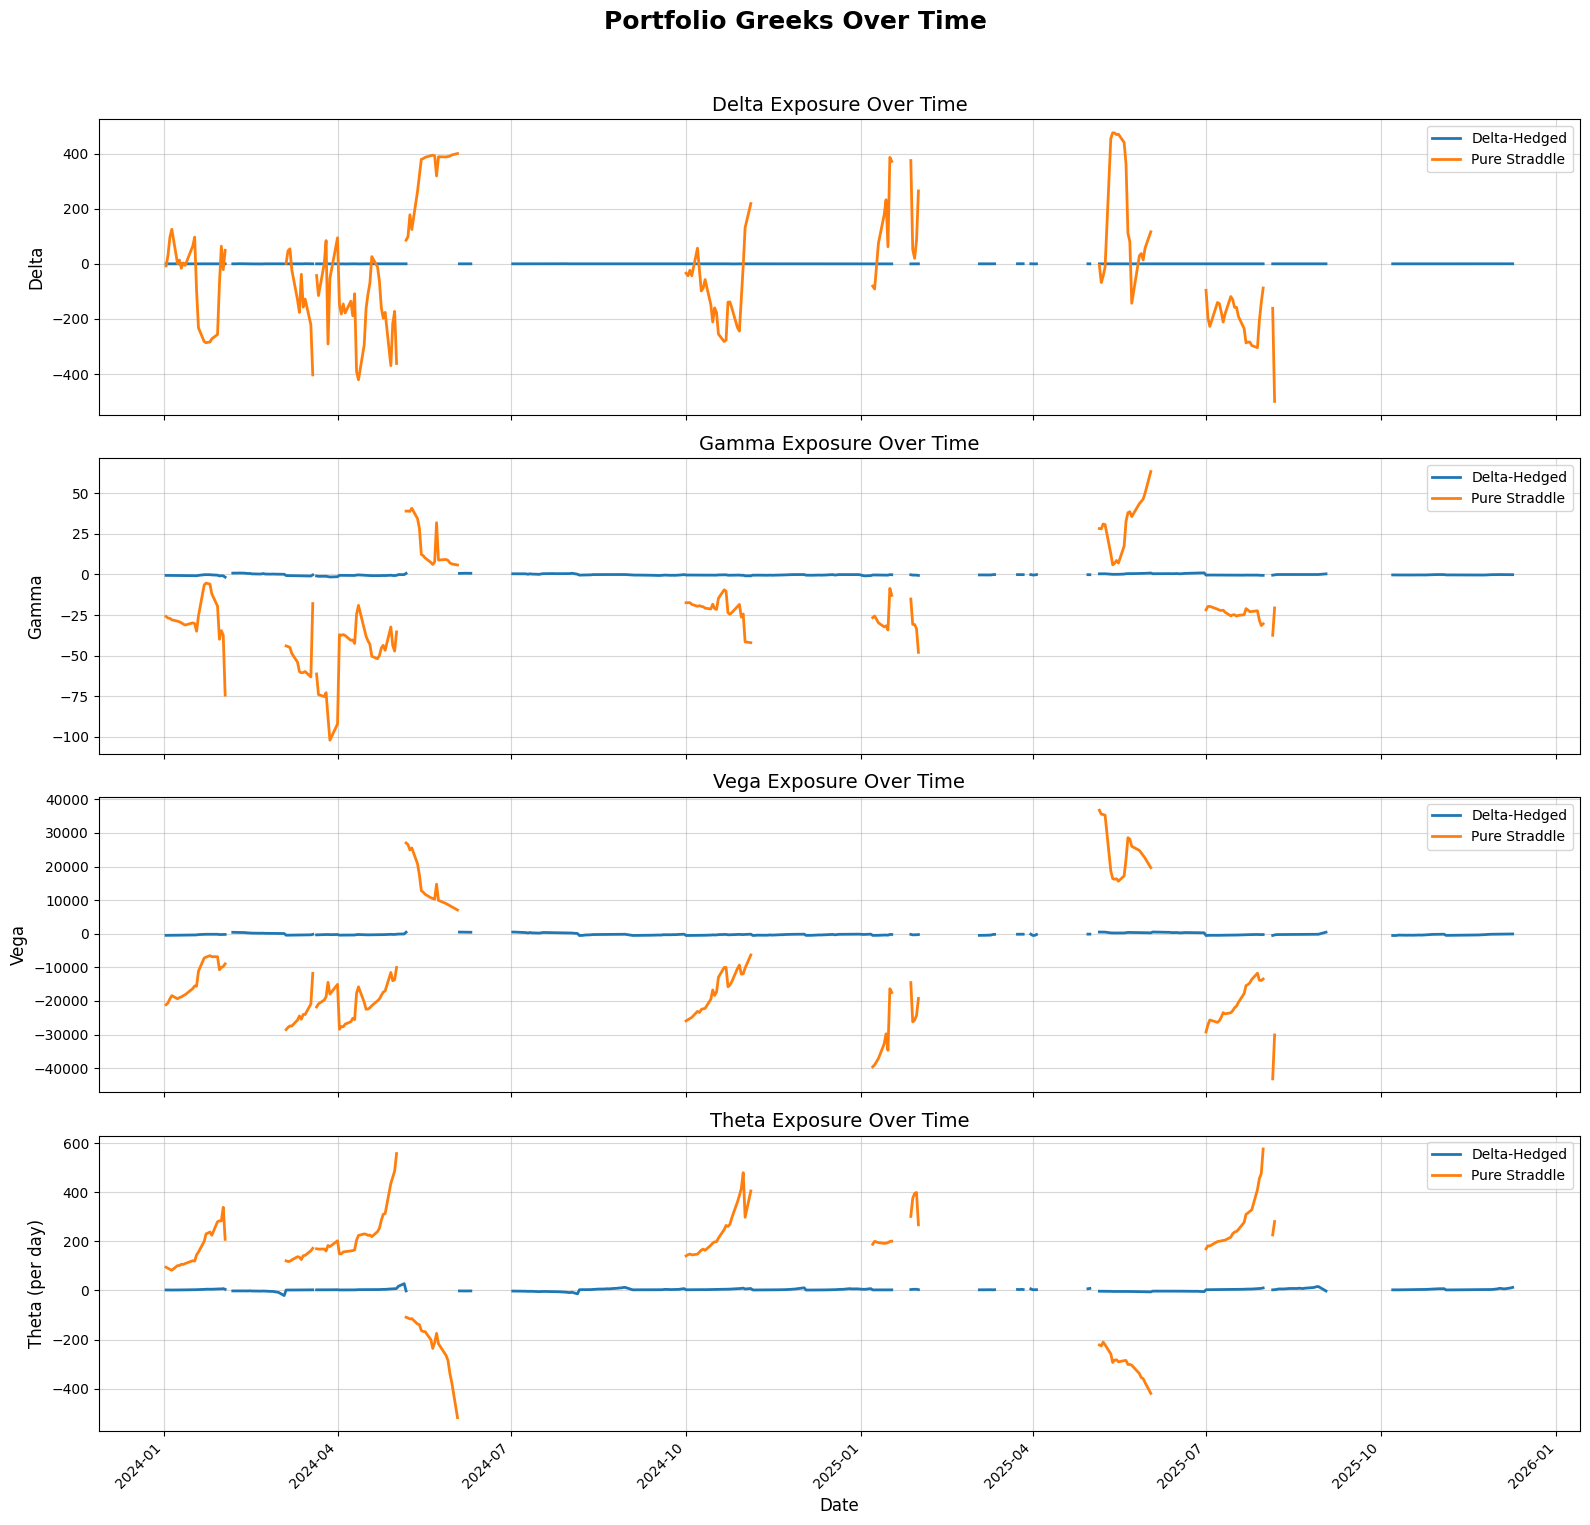

In [13]:
## Plot Portfolio Greeks

fig, axs = plt.subplots(4, 1, figsize=(16, 16), sharex=True)
fig.suptitle('Portfolio Greeks Over Time', fontsize=18, fontweight='bold')

# 1. Delta
axs[0].plot(date_idx, delta_ddh, label='Delta-Hedged', color='tab:blue', linewidth=2)
axs[0].plot(date_idx, delta_straddle, label='Pure Straddle', color='tab:orange', linewidth=2)
axs[0].set_ylabel('Delta', fontsize=12)
axs[0].set_title('Delta Exposure Over Time', fontsize=14)
axs[0].grid(True, alpha=0.5)
axs[0].legend()

# 2. Gamma
axs[1].plot(date_idx, gamma_ddh, label='Delta-Hedged', color='tab:blue', linewidth=2)
axs[1].plot(date_idx, gamma_straddle, label='Pure Straddle', color='tab:orange', linewidth=2)
axs[1].set_ylabel('Gamma', fontsize=12)
axs[1].set_title('Gamma Exposure Over Time', fontsize=14)
axs[1].grid(True, alpha=0.5)
axs[1].legend()

# 3. Vega
axs[2].plot(date_idx, vega_ddh, label='Delta-Hedged', color='tab:blue', linewidth=2)
axs[2].plot(date_idx, vega_straddle, label='Pure Straddle', color='tab:orange', linewidth=2)
axs[2].set_ylabel('Vega', fontsize=12)
axs[2].set_title('Vega Exposure Over Time', fontsize=14)
axs[2].grid(True, alpha=0.5)
axs[2].legend()

# 4. Theta
axs[3].plot(date_idx, theta_ddh, label='Delta-Hedged', color='tab:blue', linewidth=2)
axs[3].plot(date_idx, theta_straddle, label='Pure Straddle', color='tab:orange', linewidth=2)
axs[3].set_xlabel('Date', fontsize=12)
axs[3].set_ylabel('Theta (per day)', fontsize=12)
axs[3].set_title('Theta Exposure Over Time', fontsize=14)
axs[3].grid(True, alpha=0.5)
axs[3].legend()

# Format dates
for ax in axs:
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(axs[-1].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()


In [14]:
# Display Sharpe Ratios and Annual Volatility
print("=" * 60)
print("RISK-RETURN METRICS")
print("=" * 60)
print(f"\nDelta-Hedged Strategy:")
print(f"  Sharpe Ratio: {sharpe_ddh:.4f}")
print(f"  Annual Volatility: {vol_ddh:.4%}")
print(f"\nPure Straddle Strategy:")
print(f"  Sharpe Ratio: {sharpe_straddle:.4f}")
print(f"  Annual Volatility: {vol_straddle:.4%}")
print("\n" + "=" * 60)

# Display in a formatted table
metrics_df = pd.DataFrame({
    'Strategy': ['Delta-Hedged', 'Pure Straddle'],
    'Sharpe Ratio': [sharpe_ddh, sharpe_straddle],
    'Annual Volatility': [f"{vol_ddh:.4%}", f"{vol_straddle:.4%}"]
})
print("\nRisk-Return Summary:")
print(metrics_df.to_string(index=False))


RISK-RETURN METRICS

Delta-Hedged Strategy:
  Sharpe Ratio: 2.0930
  Annual Volatility: 7.4894%

Pure Straddle Strategy:
  Sharpe Ratio: 0.7595
  Annual Volatility: 51.5487%


Risk-Return Summary:
     Strategy  Sharpe Ratio Annual Volatility
 Delta-Hedged      2.093000           7.4894%
Pure Straddle      0.759507          51.5487%
